In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline 


In [3]:
booze = pd.read_csv('../iowa_liquor_sales_proj_2.csv')
booze.shape

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2709552, 24)

In [4]:
#Finding patterns for store location
import re
#tester = booze.head()
# tester
# pattern2 = r'[(].+[)]'
# tester['Store Location'].apply(lambda x: re.findall(pattern2,x))

In [5]:
booze.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S29198800001,11/20/2015,2191,Keokuk Spirits,1013 MAIN,KEOKUK,52632,"1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)",56.0,Lee,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,6,$162.84,4.50,1.19
1,S29195400002,11/21/2015,2205,Ding's Honk And Holler,900 E WASHINGTON,CLARINDA,51632,"900 E WASHINGTON\nCLARINDA 51632\n(40.739238, ...",73.0,Page,...,297,Templeton Rye w/Flask,6,750,$18.09,$27.14,12,$325.68,9.00,2.38
2,S29050300001,11/16/2015,3549,Quicker Liquor Store,1414 48TH ST,FORT MADISON,52627,"1414 48TH ST\nFORT MADISON 52627\n(40.624226, ...",56.0,Lee,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08
3,S28867700001,11/04/2015,2513,Hy-Vee Food Store #2 / Iowa City,812 S 1ST AVE,IOWA CITY,52240,812 S 1ST AVE\nIOWA CITY 52240\n,52.0,Johnson,...,237,Knob Creek w/ Crystal Decanter,3,1750,$35.55,$53.34,3,$160.02,5.25,1.39
4,S29050800001,11/17/2015,3942,Twin Town Liquor,104 HIGHWAY 30 WEST,TOLEDO,52342,"104 HIGHWAY 30 WEST\nTOLEDO 52342\n(41.985887,...",86.0,Tama,...,249,Disaronno Amaretto Cavalli Mignon 3-50ml Pack,20,150,$6.40,$9.60,2,$19.20,0.30,0.08


In [6]:
#Converting date column to datetime format
booze['Date'] = pd.to_datetime(booze['Date'], infer_datetime_format=True)

In [7]:
#Cleaning columns to be numeric
booze['Sale (Dollars)'] = booze['Sale (Dollars)'].str.replace('$', '').astype(float)
booze['State Bottle Retail'] = booze['State Bottle Retail'].str.replace('$', '').astype(float)
booze['State Bottle Cost'] = booze['State Bottle Cost'].str.replace('$', '').astype(float)

In [8]:
#Turning non-numeric numeric columns into objects 
booze['Category'] = booze['Category'].astype(object)
booze['Vendor Number'] = booze['Vendor Number'].astype(object)
booze['Item Number'] = booze['Item Number'].astype(object)
booze['County Number'] = booze['County Number'].astype(object)
booze['Store Number'] = booze['Store Number'].astype(object)

In [9]:
#Selecting only the numeric columns
numeric_columns = []
for col in booze.columns:
    if isinstance(booze[col][0], (np.float64, np.int64)):
        numeric_columns.append(col)

In [10]:
#creating subframe to identify  outliers, standardizing
mask = booze[numeric_columns]
standard_mask = StandardScaler()
mask = pd.DataFrame(standard_mask.fit_transform(mask), columns=numeric_columns)

In [11]:
#LOCATING OUTLIERS and DROPPING THEM
index_list = []

for col in mask.columns: 
    df = mask.loc[(mask[col] > 6) | (mask[col] < -6)]
    index_list.extend(list(df.index))

index_list = list(set(index_list))

todrop = mask.iloc[index_list]

#Exploring outliers- the outliers seem well dispersed between cities
booze.iloc[index_list].groupby('City')[['Store Number']].nunique()
#The types of liquors prevalent in the subgroup are also dispersed between brand types 
booze.iloc[index_list].groupby('Item Description')[['Store Number']].nunique().sort_values(by='Store Number', ascending=False)

#Will run with and without these outliers, creating subset with outliers removed,
#dropped observations represent less than 0.5% of observations and are more than 6 standard
#deviations from the mean
booze_cleaned = booze.drop(todrop.index)
mask = mask.drop(todrop.index)

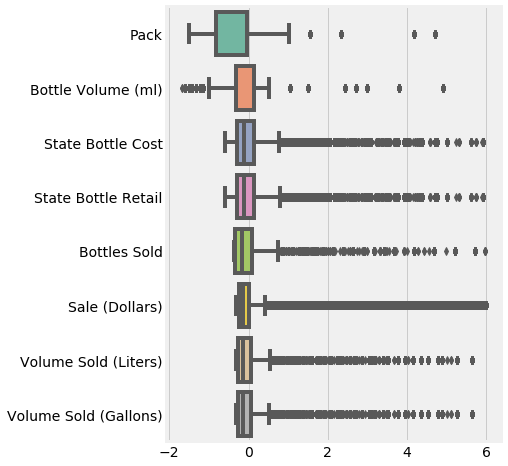

In [12]:
#Looking at distributions
#The outliers from pack size appear to be reasonable
#the fireball mini dispenser comprises 92% of the bottle volume outliers above 2 stds. This is ok. 
#Most outliers explained by the peculiarity of brand or the purpose of store (primarily liquor store/not liquor store)
#USE two lines of code below code to explore further, replacing column as aprpriorate
#list_pack = list(mask.loc[mask['Bottles Sold'] > 3].index)
# booze.iloc[list_pack]
fig = plt.figure(figsize=(6, 8))
plt.style.use('fivethirtyeight')
ax = sns.boxplot(data=mask, orient="h", palette="Set2")

In [13]:
#Splitting between 2015 and 2016
mask_dates = (booze_cleaned['Date'] > '12/31/2014') & (booze_cleaned['Date'] < '1/1/2016')
booze_2015 = booze_cleaned.loc[mask_dates]
mask_dates2 = (booze_cleaned['Date'] > '12/31/2015')
booze_2016 = booze_cleaned.loc[mask_dates2]

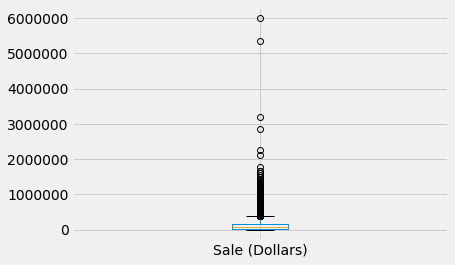

In [112]:
#Creating my 2015 target variable, and examining dispersion of sales data
target = booze_2015.groupby('Store Number')[['Sale (Dollars)']].sum()
target.plot.box()

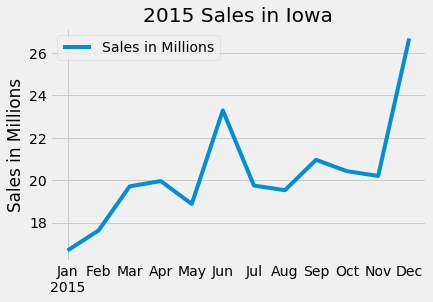

In [111]:
#Creating a chart for monthly total sales in Iowa 2015
booze_2015_charts = booze_2015.copy()
booze_2015_charts = booze_2015_charts.set_index('Date').resample('M')[['Sale (Dollars)']].sum()
booze_2015_charts['Sales in Millions'] = booze_2015_charts['Sale (Dollars)'] / 1000000
booze_2015_charts['Sales in Millions'].plot()
plt.legend()
plt.ylabel('Sales in Millions')
plt.xlabel('')
plt.title('2015 Sales in Iowa')
plt.show()

In [155]:
X_booze = booze_2015.groupby('Store Number')[['State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Gallons)']].sum().reset_index(level=0)

In [186]:
#Merging demographic details with X_booze
x_county = booze_2015.drop_duplicates(subset=['Store Number', 'County'])

#Removing duplicate county (because of NaN value)
mask3 = x_county[x_county['Store Number'].duplicated(keep=False)]
x_county = x_county[['County', 'Store Number']].drop([469])

#Merge beginning
x_first = pd.merge(X_booze, x_county, on='Store Number')

#Cleaning county demographics
county_demographics = pd.read_csv('../IowaDemographics.csv',index_col=0)
county_demographics['Areaname'] = county_demographics['Areaname'].str.split(',', expand=True)
county_demographics = county_demographics.drop('Median household income 2005', axis=1)
county_demographics['Median household income 2009 (thousands)']= county_demographics['Median household income 2009'] / 1000

#Merging
X = pd.merge(x_first, county_demographics, left_on='County', right_on='Areaname')
X = X.drop('Areaname', axis = 1)
X = X.drop('Sale (Dollars)', axis=1)


In [272]:
#Creating first three months variable
mask_dates_two = (booze_2015['Date'] > '12/31/2014') & (booze_2015['Date'] < '4/1/2015')
three_months = booze_2015[mask_dates_two]
three_months = three_months.groupby('Store Number')['Sale (Dollars)'].sum().reset_index(level=0)

#91 stores didn't have sales in the first three months of 2015
missing_stores = list(set(X['Store Number']) - set(three_months['Store Number']))
monthly_sales_missing = booze_2015[booze_2015['Store Number'].isin(missing_stores)].set_index(['Date']).resample('M')['Sale (Dollars)'].sum()

In [274]:
#Taking the average sales  from the worst month (January) and extrapolating (conservatively) on that
# 16684491 / (1373 - 91)
missing_stores_sim = pd.DataFrame({'Store Number': missing_stores, 'Three months (thousands)': (13014 * 3)/1000})
three_months = three_months.rename(index=str, columns={'Store Number': 'Store Number',
                                                      'Sale (Dollars)': 'Three months (thousands)'})
three_months['Three months (thousands)'] = three_months['Three months (thousands)'] / 1000

In [282]:
#appending missing stores to three month variable
three_month_sales = three_months.append(missing_stores_sim).reset_index(drop=True)

#merging three month variable to X 
X = pd.merge(X, three_month_sales, on='Store Number')